## PCR Data Analysis
 + 실험 결과 데이터 := _pcr_data.xls_
 ---
 - [ ] AI 적용


In [1]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# DataFrame의 값 Line Chart 그리기
def plotData(df, columns = None, legend=None, type=None, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], 
             title=None, ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(11,3), saveto=None):
    fig = plt.figure(figsize=figsize)
    if ylim != None :
        plt.ylim(ylim[0], ylim[1])
        
    for i, col in enumerate(columns) :
        plt.plot(df[col], linewidth=1, color=color[i])
        
    # plt.grid(True, color='#f2f5f3', linestyle='-', linewidth=1)
    plt.grid(True, axis='y', color='#f2f5f3', alpha=0.5, linestyle='--')
    plt.grid(True, axis='x', color='#f2f5f3', alpha=0.5, linestyle='--')
    if title != None :
        plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12, labelpad=13) ; 
    plt.xlabel(xlabel, fontsize=12, labelpad=8)
    if legend == None :
        legend = columns
    _legend = plt.legend(legend, prop={'size': 13})
    _legend.get_frame().set_alpha(None)
    _legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    plt.autoscale(enable=True, axis='x', tight=True)
    #     plt.axhline(y=10.0, color='r', linewidth=2)
    # plt.axhline(y=9.8, linewidth=2, color='#ff0000')
    #     plt.axvline(x=datetime(2019, 1, 1), color='r', linestyle=':', linewidth=1)
    if saveto != None :
        #plt.close(fig)
        plt.savefig(saveto)
    else :
        plt.show()

# plotData(df_day, columns=['diff1', 'pre1', 'pred1'], 
#          ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(11,3))

In [2]:
import pandas as pd
import numpy as np
import keras


In [4]:
#--------------------------------------------------------- pcr_data.csv 파일 Loading
filename ='pcr_raw.xls'
# df0 = pd.read_excel(filename, skiprows=7)#, encoding='utf8')  # --> 오류 발생

import xlrd
workbook = xlrd.open_workbook(filename, ignore_workbook_corruption=True)  # --> 이렇게 해야 최신 Excel 파일 Read 가능
df0 = pd.read_excel(workbook, header=None)#, skiprows=5)

machine_type = df0[df0[0] == 'Machine Type'][1].values[0]      #----------- PCR Machine Type 확인
header_i = df0[df0[0] == 'Well'].index[0]                      #----------- 실제 Data만 Cutting
df0.columns = ['Well Number', 'Well', 'Cycle', 'Target', 'Rn', 'dRn']
df0 = df0[header_i+1:]
df0

,Well Number,Well,Cycle,Target,Rn,dRn
6,1,A1,1,Target 1,2.961501,-0.139089
7,1,A1,2,Target 1,3.022252,-0.093785
8,1,A1,3,Target 1,3.12047,-0.011014
9,1,A1,4,Target 1,3.158359,0.011427
10,1,A1,5,Target 1,3.171593,0.009214
...,...,...,...,...,...,...
15361,96,H12,36,Target 4,0.059356,0.007417
15362,96,H12,37,Target 4,0.065078,0.013154
15363,96,H12,38,Target 4,0.070098,0.018188
15364,96,H12,39,Target 4,0.078637,0.026742


In [ ]:
# df0[(df0['Well'] == 'A1') & (df0['Target'] == f'Target 1')]["dRn"].values

### 94 x 4 column의 DataFrame 만들기

In [7]:
def changeDataFrameForPlot(df0):
    df = pd.DataFrame()
    cols = []
    for sample in range(1, 13) :
        for i in range(65, 73) :
            well =f"{chr(i)}{sample}" 
            for target in range(1, 5) :
                vals = df0[(df0['Well'] == well) & (df0['Target'] == f'Target {target}')]["dRn"].values
    #             print(len(vals))
    #             vals = np.round(vals, 2)
                if len(vals) > 0 :
                    if len(cols) == 0 :
                        df['Cycle'] = df0[(df0['Well'] == well) & (df0['Target'] == f'Target {target}')]["Cycle"].values
                        #cols.append('Cycle')
                    vname = f'{well}_{target}'
                    df[vname] = vals
                    cols.append(vname)
    #                 print(f"{vname} == ", vals)
    return df
# print(cols) # , end=" ")

df = changeDataFrameForPlot(df0)

C:\Users\정호찡\AppData\Local\Temp/ipykernel_18984/2083545680.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[vname] = vals


In [9]:
df

,Cycle,A1_1,A1_2,A1_3,A1_4,B1_1,B1_2,B1_3,B1_4,C1_1,...,F12_3,F12_4,G12_1,G12_2,G12_3,G12_4,H12_1,H12_2,H12_3,H12_4
0,1,-0.139089,-0.333555,0.036977,-0.150388,-1.269598,-0.802777,0.054833,-0.441232,-1.078084,...,0.073244,-0.87631,-1.537175,-0.920695,0.010397,0.005926,-0.744428,-0.260346,0.0381,-0.004185
1,2,-0.093785,-0.217413,0.028578,-0.10081,-1.200599,-0.75781,0.052378,-0.416412,-1.010052,...,0.073008,-0.844557,-1.473746,-0.883524,0.009629,0.004181,-0.721655,-0.255862,0.03584,-0.003286
2,3,-0.011014,-0.041861,0.00687,-0.020589,-1.00901,-0.629203,0.042388,-0.344158,-0.844596,...,0.06604,-0.72922,-1.308655,-0.772823,0.007619,0.001514,-0.64305,-0.233326,0.034728,-0.008668
3,4,0.011427,0.00737,-0.003852,-0.006429,-0.815348,-0.491704,0.035263,-0.273353,-0.674958,...,0.05386,-0.617796,-1.142453,-0.677245,0.008348,0.000941,-0.583737,-0.208274,0.03039,-0.008138
4,5,0.009214,0.021268,-0.003385,0.007252,-0.598056,-0.35419,0.025431,-0.189079,-0.499617,...,0.03947,-0.503922,-0.941428,-0.534818,0.007393,0.002725,-0.502528,-0.167498,0.024254,-0.000042
5,6,0.019519,0.018441,-0.000664,0.007064,-0.343032,-0.197693,0.01427,-0.098423,-0.325272,...,0.028909,-0.389771,-0.720722,-0.398079,0.009959,0.001648,-0.374553,-0.12134,0.018382,0.003266
6,7,0.028217,0.015709,-0.000247,0.001092,-0.095496,-0.067127,0.006967,-0.032077,-0.172556,...,0.014105,-0.256019,-0.473031,-0.239859,0.007932,-0.002749,-0.257967,-0.080819,0.012452,0.005288
7,8,0.023251,0.009011,-0.00358,0.0029,-0.052553,-0.01583,0.002261,-0.006397,-0.063706,...,0.000752,-0.136612,-0.266168,-0.101016,0.003781,-0.004368,-0.125166,-0.033064,0.010432,-0.000104
8,9,0.000179,-0.00402,0.000362,-0.010009,-0.053418,-0.007442,0.000063,-0.002129,-0.009757,...,-0.003653,-0.052511,-0.098655,0.012898,0.001197,-0.002824,-0.044793,0.000303,0.00888,-0.001147
9,10,0.002969,-0.009082,-0.003018,-0.004624,-0.063127,-0.011894,0.000546,-0.004286,0.019557,...,-0.005696,-0.028189,-0.011846,0.046399,0.00026,0.005042,-0.027293,0.014247,0.005609,0.001427


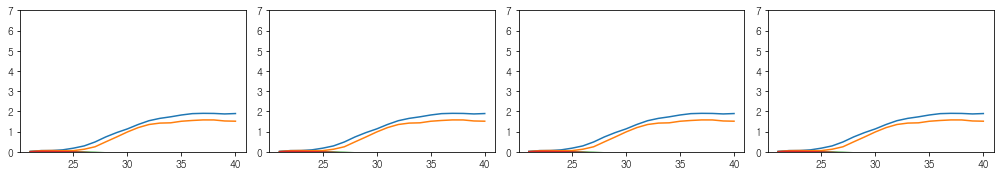

In [10]:
draw_from = 20
draw_to   = 40
df1 = df[draw_from:draw_to]

plt.subplots(figsize=(14, 2.5))
plt.subplot(1,4, 1)
plt.plot(df1['Cycle'], df1[['A1_1', 'A1_2', 'A1_3', 'A1_4']])
plt.ylim(0, 7)
plt.subplot(1,4, 2)
plt.ylim(0, 7)
plt.plot(df1['Cycle'], df1[['A1_1', 'A1_2', 'A1_3', 'A1_4']])
plt.subplot(1,4, 3)
plt.ylim(0, 7)
plt.plot(df1['Cycle'], df1[['A1_1', 'A1_2', 'A1_3', 'A1_4']])
plt.subplot(1,4, 4)
plt.ylim(0, 7)
plt.plot(df1['Cycle'], df1[['A1_1', 'A1_2', 'A1_3', 'A1_4']])

plt.tight_layout()
plt.show()

### Chart 그리기

In [12]:
sample = 12
def drawSample(sample, df) :
    n_columns = 4
    print(f'Sample-{sample}')
    count = 0
    colors=["red", "dodgerblue", "violet", "#fca817"] #"green"]
    for i in range(65, 73) :
        _col = []
        if count == 0 :
            plt.subplots(figsize=(15, 2*8/n_columns))
        count += 1

        plt.subplot(int(8/n_columns), n_columns, count)
        plt.title(f"{chr(i)}{sample}")
        plt.legend(["T-1", "T-2", "T-3", "-4"])
        plt.ylim(0, 7)
        plt.grid(True, color='gray', alpha=0.3, linestyle='--') # , axis='y')

        for j in range(1, 5) :
            well = f"{chr(i)}{sample}_{j}"
            _col.append(well)
            plt.plot(df['Cycle'], df[well], color=colors[j-1], alpha=1)

        if count >= n_columns :
            plt.tight_layout()
            plt.show()
            count = 0
# drawSample(4)

def drawAllWellChart(df) :
    for i in range(1, 13):
        drawSample(i, df)
        
# drawAllWellChart(df1)

Sample-4


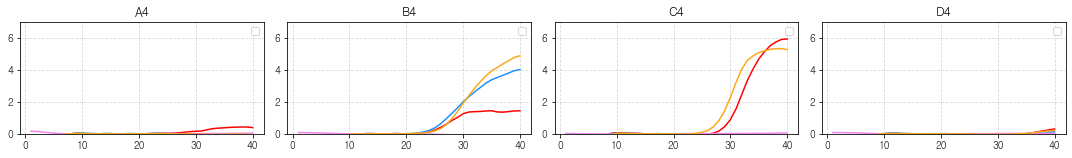

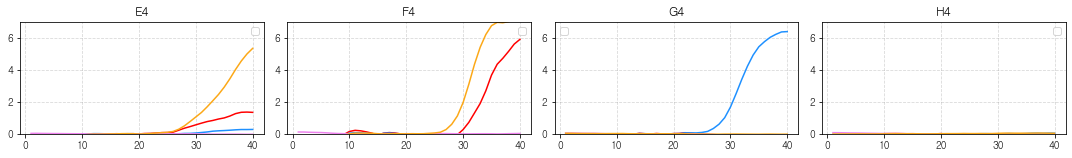

In [14]:
drawSample(4,df)

## 전처리 --> Training Data 준비

### Data Transform for Training
* Abnormal Data : 생략
* 누락 Data : 생략
* NaN Data : 생략
* 중복 Data : 생략

### 한 줄에 하나의 Signal Data

In [27]:
vals = []
def changeDataFrameForTraining(df0):
    global vals
    _cols = [i for i in range(1,41)]
    df = pd.DataFrame(columns = _cols)

    for sample in range(1, 13) :
        for i in range(65, 73) :
            well =f"{chr(i)}{sample}" 
            for target in range(1, 5) :
                vals = df0[(df0['Well'] == well) & (df0['Target'] == f'Target {target}')]["dRn"].values
#                 P_Ct_Rn   = signalCt_Rn(vals)
#                 P_Th_Ct   = signalTh_Ct(vals)
#                 P_Rn_Last = signalRn_Last(vlas)

                df.loc[len(df)] = vals
    return df
# print(cols) # , end=" ")

tdf = changeDataFrameForTraining(df0)
tdf

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
0,-0.139089,-0.093785,-0.011014,0.011427,0.009214,0.019519,0.028217,0.023251,0.000179,0.002969,...,1.352938,1.539780,1.655031,1.731662,1.822408,1.889459,1.903929,1.899017,1.874439,1.893778
1,-0.333555,-0.217413,-0.041861,0.007370,0.021268,0.018441,0.015709,0.009011,-0.004020,-0.009082,...,1.198025,1.351615,1.420886,1.434573,1.512535,1.550456,1.578156,1.577128,1.526210,1.514968
2,0.036977,0.028578,0.006870,-0.003852,-0.003385,-0.000664,-0.000247,-0.003580,0.000362,-0.003018,...,-0.071786,-0.076241,-0.076324,-0.076446,-0.080206,-0.083378,-0.085305,-0.089431,-0.082265,-0.077375
3,-0.150388,-0.100810,-0.020589,-0.006429,0.007252,0.007064,0.001092,0.002900,-0.010009,-0.004624,...,-0.144495,-0.145998,-0.153694,-0.181487,-0.175831,-0.165145,-0.167023,-0.184907,-0.229609,-0.247051
4,-1.269598,-1.200599,-1.009010,-0.815348,-0.598056,-0.343032,-0.095496,-0.052553,-0.053418,-0.063127,...,-0.024779,-0.044751,-0.047601,-0.002627,-0.009256,-0.052764,-0.068700,-0.079186,-0.072686,-0.089156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.005926,0.004181,0.001514,0.000941,0.002725,0.001648,-0.002749,-0.004368,-0.002824,0.005042,...,0.004853,0.007163,0.005529,0.004395,0.006800,0.005009,-0.000298,-0.003011,-0.002481,0.003487
380,-0.744428,-0.721655,-0.643050,-0.583737,-0.502528,-0.374553,-0.257967,-0.125166,-0.044793,-0.027293,...,0.951790,1.448975,1.967937,2.663155,3.377163,3.919736,4.431586,4.815920,5.082513,5.217967
381,-0.260346,-0.255862,-0.233326,-0.208274,-0.167498,-0.121340,-0.080819,-0.033064,0.000303,0.014247,...,-0.016190,-0.029965,-0.053106,-0.061454,-0.072103,-0.075976,-0.077323,-0.087433,-0.098613,-0.102440
382,0.038100,0.035840,0.034728,0.030390,0.024254,0.018382,0.012452,0.010432,0.008880,0.005609,...,-0.003121,-0.002994,-0.008396,-0.006595,0.002466,0.000822,0.001860,0.010148,0.011385,0.010748


### CT_Rn 값으로 Signal 유무 판단

In [28]:
Th = 0.2
Ct_Cycle = 30     # 증폭 Cycle 30번에서 dRn 값이 Th 값을 넘는가?
Rn_Last_Base = 5  # Rn(40) 값의 기준은 Th 값의 5배

def P_Ct_Rn(data):
    base_table = [[0.2, 0], [0.4, 0.01], [0.6, 0.03], [0.7, 0.1], [0.8, 0.2], [0.9, 0.35], [1, 0.6], [1.3, 0.78], [1.5, 0.9], [1.7, 0.95], [1.9, 0.98], [2.1, 0.99], [2.5, 1]]
    
    Ct_Rn = data[Ct_Cycle - 1]
    P_Ct_Rn = 1.0
    
    for i in range(0, len(base_table)):
        if Ct_Rn <= base_table[i][0] * Th :
            P_Ct_Rn = base_table[i][1]
            print (f"CT_Rn({Ct_Rn} --> Signal 확률 = {P_Ct_Rn})")
            break
            
    return P_Ct_Rn
        
P_Ct_Rn(vals)

CT_Rn(0.0010951800005776571 --> Signal 확률 = 0)


0

### Th 값 최초 초과 CT Cycle #로  Signal 유무 판단

In [29]:
def P_Th_Ct(data):
#     base_table = [{-6 : 1}, {-5 : 0.99}, {-4 : 0.98}, {-3 : 0.96}, {-2 : 0.9}, {-1 : 0.78}, {0 : 0.6}, {1 : 0.38}, {2 : 0.2}, {3 : 0.1}, {4 : 0.03}, {5 : 0.01}, {6 : 0}]
    base_table = { -6 : 1, -5 : 0.99, -4 : 0.98, -3 : 0.96, -2 : 0.9, -1 : 0.78, 0 : 0.6, 1 : 0.45, 2 : 0.3, 3 : 0.1, 4 : 0.03, 5 : 0.01, 6 : 0}
    
    Th_Ct = 6
    P_Th_Ct = 0.0
    for i in range(0, len(data)) :
        if data[i] >= Th :
            Th_Ct = i + 1
            diff_Th_Ct = Th_Ct - Ct_Cycle
            if diff_Th_Ct < -6 :
                diff_Th_Ct = -6
            if diff_Th_Ct > 6 :
                diff_Th_Ct = 6
                
            P_Th_Ct = base_table[diff_Th_Ct]
            print (f"Th_Ct({Th_Ct} --> Signal 확률 = {P_Th_Ct})")
            return P_Th_Ct
    
    print (f"Th_Ct(Th 도달 못함) --> Signal 확률 = {P_Th_Ct})")
    return P_Th_Ct

    
P_Th_Ct(vals)

Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)


0.0

### Last Cycle dRn 값으로  Signal 유무 판단

In [30]:
def P_Rn_Last(data):
    base_table = [[0.5, 0], [1, 0.01], [2, 0.03], [2.5, 0.1], [3, 0.2], [3.5, 0.35], [5, 0.6], [6, 0.78], [7, 0.9], [8, 0.96], [9, 0.98], [10, 0.99], [11, 1]]
    
    Rn_Last = data[len(data) - 1]
    P_Rn_Last = 1.0
    
    for i in range(0, len(base_table)):
        if Rn_Last <= base_table[i][0] * Th :
            P_Rn_Last = base_table[i][1]
            print (f"Rn_Last({Rn_Last} --> Signal 확률 = {P_Rn_Last})")
            break
            
    return P_Rn_Last
    
P_Rn_Last(vals)

Rn_Last(0.026404685739959986 --> Signal 확률 = 0)


0

### 세가지 조건에 따른 Signal 확률 조합하기

In [31]:
P_Final = []

def P_FinalMax(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Max ====================
    #-------------------------------------------  3 값 중 --> Max 값
    if _sel == 1 :
        _P = max([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])
    
    #-------------------------------------------  Ct_Rn & Rn_Last --> Max 값
    if _sel == 2 :
        _P = max([_P_Ct_Rn, _P_Rn_Last])
    
    #-------------------------------------------  Th_Ct & Rn_Last  --> Max 값
    if _sel == 3 :
        _P = max([_P_Th_Ct, _P_Rn_Last])
        
    return _P
    

    
def P_FinalMean(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Max ====================
    #-------------------------------------------  전체  평균 값
    if _sel == 1 :
        _P = np.mean([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])

    #-------------------------------------------  Ct_Rn & Rn_Last  평균 값
    if _sel == 2 :
        _P = np.mean([_P_Ct_Rn, _P_Rn_Last])

    #-------------------------------------------  Th_Ct & Rn_Last  평균 값
    if _sel == 3 :
        _P = np.mean([_P_Th_Ct, _P_Rn_Last])
        
    return np.round(_P, 2)

        
def P_FinalOX(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel = 1) :
    #===================== Digital : O or 1 ====================
    #-------------------------------------------  3 값 중 하나만 0.5 이상이면
    if _sel == 1 :
        _P = max([_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0
    
    #-------------------------------------------  Ct_Rn or Rn_Last  > 0.5
    if _sel == 2 :
        _P = max([_P_Ct_Rn, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0
    
    #-------------------------------------------  Th_Ct or Rn_Last  > 0.5
    if _sel == 3 :
        _P = max([_P_Th_Ct, _P_Rn_Last])
        if _P >= 0.5 :
            return 1
        else :
            return 0
    
   

### Meta Data (Signal 확률 생성)

In [32]:
def changeDataFrameForTrainingWithProbability(df0):
    _cols = [i for i in range(1,41)]
    _cols = ["P_Final_OX", "P_Final_Mean", "P_Final_Max", "P_Ct_Rn", "P_Th_Ct", "P_Rn_Last"] + _cols
    df = pd.DataFrame(columns = _cols)

    for sample in range(1, 13) :
        for i in range(65, 73) :
            well =f"{chr(i)}{sample}" 
            for target in range(1, 5) :
                vals = df0[(df0['Well'] == well) & (df0['Target'] == f'Target {target}')]["dRn"].values
                _P_Ct_Rn   = P_Ct_Rn(vals)
                _P_Th_Ct   = P_Th_Ct(vals)
                _P_Rn_Last = P_Rn_Last(vals)
                _P_FinalMax = P_FinalMax(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel=1)
                _P_FinalMean = P_FinalMean(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel=1)
                _P_FinalOX = P_FinalOX(_P_Ct_Rn, _P_Th_Ct, _P_Rn_Last, _sel=1)
                
                _vals = [_P_FinalOX, _P_FinalMean, _P_FinalMax, _P_Ct_Rn, _P_Th_Ct, _P_Rn_Last] + vals.tolist()

                df.loc[len(df)] = _vals
    return df
# print(cols) # , end=" ")

tdf = changeDataFrameForTrainingWithProbability(df0)
tdf

Th_Ct(26 --> Signal 확률 = 0.98)
Rn_Last(1.8937776542845228 --> Signal 확률 = 0.99)
Th_Ct(27 --> Signal 확률 = 0.96)
Rn_Last(1.5149678502764026 --> Signal 확률 = 0.96)
CT_Rn(-0.060331216880253336 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.07737452643258236 --> Signal 확률 = 0)
CT_Rn(-0.13375198273431707 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.24705080758957618 --> Signal 확률 = 0)
CT_Rn(-0.03742974145071809 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.0891562189374655 --> Signal 확률 = 0)
CT_Rn(-0.030940282912481333 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.06478414081391841 --> Signal 확률 = 0)
CT_Rn(0.0019587929404917153 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.021428172254846212 --> Signal 확률 = 0)
CT_Rn(-0.027328076816740397 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.013452507200695315 --> Signal 확률 = 0)
Th_Ct(28 --> Signal 확률 = 0.9)
CT_Rn(-0.02012049584

Th_Ct(26 --> Signal 확률 = 0.98)
CT_Rn(-0.06023505755833236 --> Signal 확률 = 0)
Th_Ct(39 --> Signal 확률 = 0)
Rn_Last(0.3015637738364081 --> Signal 확률 = 0.03)
CT_Rn(-0.12227644239153153 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.12325729642595566 --> Signal 확률 = 0.01)
CT_Rn(0.019961041886182057 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.01955876481674966 --> Signal 확률 = 0)
CT_Rn(-0.03312024616059809 --> Signal 확률 = 0)
Th_Ct(40 --> Signal 확률 = 0)
Rn_Last(0.2099723929450624 --> Signal 확률 = 0.03)
Th_Ct(27 --> Signal 확률 = 0.96)
Rn_Last(1.3424787521362298 --> Signal 확률 = 0.9)
CT_Rn(0.04957803090413412 --> Signal 확률 = 0.01)
Th_Ct(35 --> Signal 확률 = 0.01)
Rn_Last(0.2724648316701253 --> Signal 확률 = 0.03)
CT_Rn(-0.007857782145341234 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.02954862763484319 --> Signal 확률 = 0)
Th_Ct(27 --> Signal 확률 = 0.96)
CT_Rn(0.2644971211751302 --> Signal 확률 = 0.9)
Th_Ct(11 --> Signal 확률 = 1)
CT_Rn(-0.3837088

CT_Rn(0.2678213346572151 --> Signal 확률 = 0.9)
Th_Ct(30 --> Signal 확률 = 0.6)
Rn_Last(0.7084456057775587 --> Signal 확률 = 0.6)
CT_Rn(0.03956855123951323 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.04687820463663054 --> Signal 확률 = 0)
Th_Ct(27 --> Signal 확률 = 0.96)
Th_Ct(29 --> Signal 확률 = 0.78)
CT_Rn(-0.2760388283502489 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.5354218255905877 --> Signal 확률 = 0)
CT_Rn(-0.0038306170276233217 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.013351132827145708 --> Signal 확률 = 0)
Th_Ct(27 --> Signal 확률 = 0.96)
CT_Rn(-0.1418147768293112 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.34398739678519163 --> Signal 확률 = 0)
Th_Ct(27 --> Signal 확률 = 0.96)
CT_Rn(-0.21153160681327182 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.5393680309255918 --> Signal 확률 = 0)
CT_Rn(-0.026955840399577498 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.027085

CT_Rn(-0.05921141306559245 --> Signal 확률 = 0)
Th_Ct(37 --> Signal 확률 = 0)
Rn_Last(0.48049338658650714 --> Signal 확률 = 0.1)
CT_Rn(0.006854404296193814 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.0045747501509530025 --> Signal 확률 = 0)
CT_Rn(-0.08392213639758883 --> Signal 확률 = 0)
Th_Ct(39 --> Signal 확률 = 0)
Rn_Last(0.25289383388700926 --> Signal 확률 = 0.03)
CT_Rn(-0.1189669427417576 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.4272655986604234 --> Signal 확률 = 0)
Th_Ct(26 --> Signal 확률 = 0.98)
CT_Rn(-0.25393629996549516 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.6016633815708615 --> Signal 확률 = 0)
CT_Rn(0.02204647061548063 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(0.03941656409629754 --> Signal 확률 = 0)
Th_Ct(29 --> Signal 확률 = 0.78)
Th_Ct(28 --> Signal 확률 = 0.9)
CT_Rn(-0.13281550542229698 --> Signal 확률 = 0)
Th_Ct(Th 도달 못함) --> Signal 확률 = 0.0)
Rn_Last(-0.48441158199594136 --> Signal 확률 = 0)
CT_Rn(0.0

,P_Final_OX,P_Final_Mean,P_Final_Max,P_Ct_Rn,P_Th_Ct,P_Rn_Last,1,2,3,4,...,31,32,33,34,35,36,37,38,39,40
0,1.0,0.99,1.0,1.0,0.98,0.99,-0.139089,-0.093785,-0.011014,0.011427,...,1.352938,1.539780,1.655031,1.731662,1.822408,1.889459,1.903929,1.899017,1.874439,1.893778
1,1.0,0.97,1.0,1.0,0.96,0.96,-0.333555,-0.217413,-0.041861,0.007370,...,1.198025,1.351615,1.420886,1.434573,1.512535,1.550456,1.578156,1.577128,1.526210,1.514968
2,0.0,0.00,0.0,0.0,0.00,0.00,0.036977,0.028578,0.006870,-0.003852,...,-0.071786,-0.076241,-0.076324,-0.076446,-0.080206,-0.083378,-0.085305,-0.089431,-0.082265,-0.077375
3,0.0,0.00,0.0,0.0,0.00,0.00,-0.150388,-0.100810,-0.020589,-0.006429,...,-0.144495,-0.145998,-0.153694,-0.181487,-0.175831,-0.165145,-0.167023,-0.184907,-0.229609,-0.247051
4,0.0,0.00,0.0,0.0,0.00,0.00,-1.269598,-1.200599,-1.009010,-0.815348,...,-0.024779,-0.044751,-0.047601,-0.002627,-0.009256,-0.052764,-0.068700,-0.079186,-0.072686,-0.089156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.0,0.00,0.0,0.0,0.00,0.00,0.005926,0.004181,0.001514,0.000941,...,0.004853,0.007163,0.005529,0.004395,0.006800,0.005009,-0.000298,-0.003011,-0.002481,0.003487
380,1.0,0.97,1.0,1.0,0.90,1.00,-0.744428,-0.721655,-0.643050,-0.583737,...,0.951790,1.448975,1.967937,2.663155,3.377163,3.919736,4.431586,4.815920,5.082513,5.217967
381,0.0,0.00,0.0,0.0,0.00,0.00,-0.260346,-0.255862,-0.233326,-0.208274,...,-0.016190,-0.029965,-0.053106,-0.061454,-0.072103,-0.075976,-0.077323,-0.087433,-0.098613,-0.102440
382,0.0,0.00,0.0,0.0,0.00,0.00,0.038100,0.035840,0.034728,0.030390,...,-0.003121,-0.002994,-0.008396,-0.006595,0.002466,0.000822,0.001860,0.010148,0.011385,0.010748


In [33]:
#--------------------------------------------------------- 전처리 데이터 저장 to pcr_pre.csv
tdf.to_csv("pcr_pre.csv", encoding='euckr', index=False)


In [34]:
filename = "pcr_pre.csv"
dfp = pd.read_csv(filename, encoding='euckr')
dfp

,P_Final_OX,P_Final_Mean,P_Final_Max,P_Ct_Rn,P_Th_Ct,P_Rn_Last,1,2,3,4,...,31,32,33,34,35,36,37,38,39,40
0,1.0,0.99,1.0,1.0,0.98,0.99,-0.139089,-0.093785,-0.011014,0.011427,...,1.352938,1.539780,1.655031,1.731662,1.822408,1.889459,1.903929,1.899017,1.874439,1.893778
1,1.0,0.97,1.0,1.0,0.96,0.96,-0.333555,-0.217413,-0.041861,0.007370,...,1.198025,1.351615,1.420886,1.434573,1.512535,1.550456,1.578156,1.577128,1.526210,1.514968
2,0.0,0.00,0.0,0.0,0.00,0.00,0.036977,0.028578,0.006870,-0.003852,...,-0.071786,-0.076241,-0.076324,-0.076446,-0.080206,-0.083378,-0.085305,-0.089431,-0.082265,-0.077375
3,0.0,0.00,0.0,0.0,0.00,0.00,-0.150388,-0.100810,-0.020589,-0.006429,...,-0.144495,-0.145998,-0.153694,-0.181487,-0.175831,-0.165145,-0.167023,-0.184907,-0.229609,-0.247051
4,0.0,0.00,0.0,0.0,0.00,0.00,-1.269598,-1.200599,-1.009010,-0.815348,...,-0.024779,-0.044751,-0.047601,-0.002627,-0.009256,-0.052764,-0.068700,-0.079186,-0.072686,-0.089156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.0,0.00,0.0,0.0,0.00,0.00,0.005926,0.004181,0.001514,0.000941,...,0.004853,0.007163,0.005529,0.004395,0.006800,0.005009,-0.000298,-0.003011,-0.002481,0.003487
380,1.0,0.97,1.0,1.0,0.90,1.00,-0.744428,-0.721655,-0.643050,-0.583737,...,0.951790,1.448975,1.967937,2.663155,3.377163,3.919736,4.431586,4.815920,5.082513,5.217967
381,0.0,0.00,0.0,0.0,0.00,0.00,-0.260346,-0.255862,-0.233326,-0.208274,...,-0.016190,-0.029965,-0.053106,-0.061454,-0.072103,-0.075976,-0.077323,-0.087433,-0.098613,-0.102440
382,0.0,0.00,0.0,0.0,0.00,0.00,0.038100,0.035840,0.034728,0.030390,...,-0.003121,-0.002994,-0.008396,-0.006595,0.002466,0.000822,0.001860,0.010148,0.011385,0.010748
